# Spectral fitting example

To run this, you need to download FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5.zip from https://drive.google.com/drive/folders/1Ex_z7vsr1ZQZjT15UUUjor8fpIOUPvhT. 
This file must be unzipped and moved to cosipy/cosipy/test_data.

The goal of this notebook is to get familiar with 3ML and get a concrete idea on the spectral fitting will work. 

[3ML](https://threeml.readthedocs.io/) is a high-level interface that allows multiple dataset form different instruments to be used coherently to fit the parameters of source model. A source model typically consists on a list of sources with a parametrized spectral shapes, sky locations and, for extended sources, shape. Polarization is also possible. A "coherent" analysis, in this context, means that the source model parameters are fitted using all available datasets simultanously, rather than performing individual fits and finding a well-suited common model a posteriori. 

In order for a dataset to be included in 3ML, each instrument needs to provide a "plugin". Each plugin is responsible for reading the data, convolving the source model (provided by 3ML) with the instrument response, and returning a likelihood. In our case, we'll compute a binned Poisson likelihood:

$$
\log \mathcal{L}(\mathbf{x}) = \sum_i \log \frac{\lambda_i(\mathbf{x})^{d_i} \exp (-\lambda_i)}{d_i!}
$$

where $d_i$ are the counts on each bin and $\lambda_i$ are the _expected_ counts, given a source model with parameters $\mathbf{x}$. 

In this example, we will fit a single point source with a known location. We'll assume the background is known and fixed. Finally, we will fit a power law:

$$
F(E) = K \left(\frac{E}{E_{piv}}\right)^{-index}
$$


where $K$ (normalization) and the spectral index are the only free parameters, while $E_{piv}$ is the pivot energy which is fixed (and arbitrary).

Considering these assumptions:

$$
\lambda_i(\mathbf{x}) = b_i + s_i(\mathbf{x}) = b_i + s_i(\mathrm{norm}, \mathrm{index})
$$

where $b_i$ are the estimated counts due to background on each bin, and $s_i$ are the corresponding expected counts from the source.

The goal is then to find the values of $\mathbf{x} = [\mathrm{norm}, \mathrm{index}]$ that maximize $\mathcal{L}$. These are the best estimation of the parameters.

The final module needs to also fit the background, handle multiple point-like and extended sources, as well as all the spectral models supported by 3ML. Eventually, it will also fit the polarization angle. However, this simple example already contains all the necessary pieces to do a fit.

In [1]:
from cosipy import COSILike, test_data
from cosipy.coordinates import SpacecraftFrame, Attitude

from histpy import Histogram

from astropy.time import Time
import astropy.units as u

import numpy as np
import matplotlib.pyplot as plt

from threeML import Powerlaw, PointSource, Model, JointLikelihood, DataList

16:23:59 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=763652;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=785408;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=398524;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=881629;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=311134;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=645618;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=322156;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=476756;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=481161;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=171421;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=821305;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=584806;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of F to 1e-99 because there was a postive transform   ]8;id=883242;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=412290;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=853495;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=604239;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

16:23:59 INFO      Starting 3ML!                                                                     ]8;id=954464;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=387302;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=730763;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=335969;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=879304;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=358389;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=197607;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=909744;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   ROOT minimizer not available                                                ]8;id=977645;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=27471;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=492099;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=123819;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=918989;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=227170;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

         WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=389108;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=909292;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=813394;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=481175;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=641565;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=792784;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   No fermitools installed                                              ]8;id=532904;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=699004;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=209141;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=652647;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=125003;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=844140;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=998866;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=166865;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

In [2]:
# Inputs needed by the COSI plugin
# We'll use fake data from the "Source injector" tutorial

dr = test_data.path / "FlatContinuumIsotropic.LowRes.binnedimaging.imagingresponse.area.nside8.cosipy.h5"

data = Histogram.open(test_data.path / "data_pl.h5")
bkg = Histogram.open(test_data.path / "bkg_pl.h5")
signal = Histogram.open(test_data.path / "signal_pl.h5")

# 1s duration. Spacecraft aligned with the ICRS ([0,0,0,1] = Identity)
sc_orientation = [(Time('2025-01-01T13:02:01.00'), Attitude.from_quat([0,0,0,1])), 
                  (Time('2025-01-01T13:02:02.00'), Attitude.from_quat([0,0,0,1]))]

# Instantiate the plugin
# Note that we'll use 3x the signal we injected before. 
cosi = COSILike("cosi",
                dr = dr,
                data = bkg + 3*signal, 
                bkg = bkg, 
                sc_orientation = sc_orientation)

In [3]:
# Our model will contain a single source with a power law
# Setting the parameter to something reasonable helps the fitting to converge
spectrum = Powerlaw()
index = -2
piv = 500 * u.keV
K = spectrum(500) / u.cm / u.cm / u.s / u.keV
spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

# Point source instance, at the know location (from the "Source Injectior" tutorial)
source = PointSource("source", # The name of the source is arbitrary, but needs to be unique
                     ra = 20, # deg 
                     dec = 40, # deg
                     spectral_shape = spectrum)

# Adding the source to the model
# If we had multiple sources, we would do Model(source1, source2, ...)
model = Model(source)

# Optional: if you want to call get_log_like manually, then you also need to set the model manually
# 3ML does this internally during the fit though
cosi.set_model(model)

In [4]:
# Define the injected parameters (from the "Source Injectior" tutorial)
K_inj = 3e-1 # 1/keV/cm2/s (3x the injected signal)
piv_inj = 1 # keV
index_inj = -1.7

In [5]:
# Gather all plugins. 
# If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)
plugins = DataList(cosi)

# Put model and pluging together
like = JointLikelihood(model, plugins, verbose = False)

# Maximum likelihood
like.fit()

         INFO      set the minimizer to minuit                                             ]8;id=181678;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=484874;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

15:38:21 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=234579;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=375282;file:///Users/eneights/opt/anaconda3/envs/cosipy/lib/python3.9/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Powerlaw.K,(7.7 -0.9 +1.0) x 10^-6,1 / (cm2 keV s)
source.spectrum.main.Powerlaw.index,-1.70 +/- 0.15,


Correlation matrix:

1.00,0.06
0.06,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,4540.459283
total,4540.459283


Values of statistical measures:

,statistical measures
AIC,9078.918565
BIC,9080.918565


(                                        value  negative_error  positive_error  \
 source.spectrum.main.Powerlaw.K      0.000008   -8.489337e-07    9.587966e-07   
 source.spectrum.main.Powerlaw.index -1.699954   -1.420529e-01    1.431182e-01   
 
                                             error             unit  
 source.spectrum.main.Powerlaw.K      9.038652e-07  1 / (cm2 keV s)  
 source.spectrum.main.Powerlaw.index  1.425856e-01                   ,
        -log(likelihood)
 cosi        4540.459283
 total       4540.459283)

## 3ML error propagation and plotting

The summary of the results above tell you the optimal values of `K` and `index`, as well as the errors. You typically want to propagate these into the error in the flux at different energies, and plot the spectrum. Let's do that:

Best fit values:

,result,unit
parameter,,
source.spectrum.main.Powerlaw.K,(7.7 -0.9 +1.0) x 10^-6,1 / (cm2 keV s)
source.spectrum.main.Powerlaw.index,-1.70 +/- 0.15,


Correlation matrix:

1.00,0.06
0.06,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,4540.459283
total,4540.459283


Values of statistical measures:

,statistical measures
AIC,9078.918565
BIC,9080.918565


None
  * source (point source):
    * position:
      * ra:
        * value: 20.0
        * desc: Right Ascension
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * dec:
        * value: 40.0
        * desc: Declination
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * equinox: J2000
    * spectrum:
      * main:
        * Powerlaw:
          * K:
            * value: 7.742285377189405e-06
            * desc: Normalization (differential flux at the pivot value)
            * min_value: 1.0e-30
            * max_value: 1000.0
            * unit: keV-1 s-1 cm-2
            * is_normalization: true
          * piv:
            * value: 500.0
            * desc: Pivot value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * index:
            * value: -1.699953622715638
            

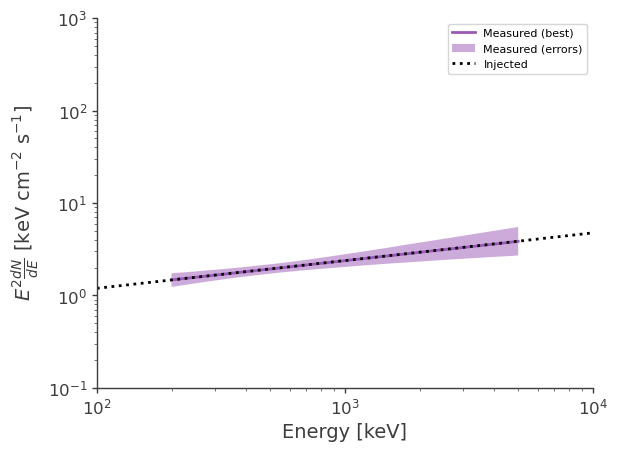

In [6]:
# Propagate the errors to the "evaluate_at" method of the spectrum
results = like.results

print(results.display())

parameters = {par.name:results.get_variates(par.path)
              for par in results.optimized_model["source"].parameters.values()
              if par.free}

results_err = results.propagate(results.optimized_model["source"].spectrum.main.shape.evaluate_at, **parameters)

print(results.optimized_model["source"])

# Evaluate at multiple energy values, for plotting
energy = np.geomspace(200*u.keV,5*u.MeV).to_value(u.keV)

flux_lo = np.zeros_like(energy)
flux_median = np.zeros_like(energy)
flux_hi = np.zeros_like(energy)

for i, e in enumerate(energy):
    flux = results_err(e)
    flux_median[i] = flux.median
    flux_lo[i], flux_hi[i] = flux.equal_tail_interval(cl=0.68)
    
# Plot
fig,ax = plt.subplots()

ax.plot(energy, energy*energy*flux_median, label = "Measured (best)")

ax.fill_between(energy, energy*energy*flux_lo, energy*energy*flux_hi, alpha = .5, label = "Measured (errors)")

energy_inj = np.geomspace(1e2, 1e4)

ax.plot(energy_inj, energy_inj*energy_inj*K_inj*(energy_inj/piv_inj)**index_inj, color = 'black', ls = ":", label = "Injected")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(1e2, 1e4)
ax.set_ylim(1e-1, 1000)

ax.set_xlabel("Energy [keV]")
ax.set_ylabel(r"$E^2 \frac{dN}{dE}$ [keV cm$^{-2}$ s$^{-1}$]")

ax.legend()